# NLP With Machine Learning

In [229]:
#import Libararies
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [192]:
# Read text file of words

FILE = '../data/terms_conditions.txt'
with open(FILE, encoding = "utf8") as f:
    clauses = f.readlines()

## More Preprocessing before ML

In [284]:
"""
    Looks through a sentence and counts how many owners or builders are in the sentence
    
    page: A page from text file
    
    returns two lists, one containing number of owners and one number of builders
    """
def count_categories(page):
    BUILDER = "builder"
    OWNER = "owner"
    owners = []
    builders = []

    for sentence in page:
        owner_count = 0
        builder_count = 0
        owner_count = sentence.lower().count(OWNER)
        builder_count = sentence.lower().count(BUILDER)
        owners.append(owner_count)
        builders.append(builder_count)
    return owners, builders
    

In [285]:
# Creating categories from the text file
# Since the contract is between owners and builders, we will assume these two to be the categories for our ml model.
own, build = count_categories(clauses)
labels = ["builder","owner", "neither"]
df_dataset = pd.DataFrame (clauses, columns = ['sentence'])
df_dataset["owner_count"] = own
df_dataset["builder_count"] = build
df_dataset["label"] = ""

In [286]:
df_dataset

,sentence,owner_count,builder_count,label
0,The Builder and the Owner have previously ente...,2,1,
1,SUSPENSION OF WORKS TERMINATION BY BUILDER TER...,4,4,
2,(Mobile): Fax: Email: +NOTE: Where the Owner i...,1,0,
3,Insurer providing Domestic Building Insurance ...,0,1,
4,The Owner/s are the registered proprietors of ...,2,0,
...,...,...,...,...
269,SCHEDULE 1 – SPECIAL CONDITIONSPAGE64Owner(s) ...,1,1,
270,SCHEDULE 3 – EXTENSION OF TIME NOTICEI hereby ...,1,0,
271,Unforeseen requirements of the Relevant Counci...,6,8,
272,Signature: Date: / / ...,0,1,


In [293]:
"""
    Looks through a dataframe and assigns one of three labels to each sentence. Assuming that if a sentence contains
    more occurences of one category then it will be about that category. IF a tie, we will assume that since the contract is 
    aimed towards builders, the sentence will be directed  to the builder
    
    df: A pandas dataframe of sentences
    label: List of labels
    
    returns a pandas dataframe with two columns, sentences and the label
    """
def assign_label(df, label):
    df.loc[df["builder_count"]>df["owner_count"],"label"] = label[0]
    df.loc[df["owner_count"]>df["builder_count"],"label"] = label[1]
    
    # If tie but not zero
    
    df.loc[((df["builder_count"] == df["owner_count"]) & df["owner_count"] != 0),"label"] = label[0]
    
    # If neither 
    df.loc[df["label"] == ""] = label[2]

    return df

In [294]:
new_df = assign_label(df_dataset, labels)
new_df["label"].value_counts().sort_index()

builder    149
neither     76
owner       49
Name: label, dtype: int64

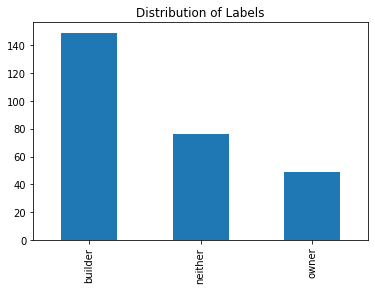

In [295]:
new_df.label.value_counts().plot(kind = "bar")
plt.title("Distribution of Labels")
plt.show()

Seeing the distribution of builder and owner, the clauses seem to be skewed towards the builder. However, this may be biased due to the assumption that this contract is directed to the builder, therefore with any ties in the number of occurences, this was set to being directed at the builder. This may not actually be the case. 

In [303]:
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(new_df["sentence"], new_df["label"], test_size=0.33, random_state=42)

In [304]:
# text preprocessing, remove stop words and vectorizersing using sklearn
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(X_train)
X_train_count.shape
X_test_count = count_vect.transform(X_test)

In [305]:
# Apply tf transformation on train set
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_count)
X_train_tf = tf_transformer.transform(X_train_count)
X_test_tf = tf_transformer.transform(X_test_count)

## Training the Neural Network Classifier

In [306]:
# Baseline
base =  MultinomialNB().fit(X_train_tf,y_train)
base_pred = base.predict(X_test_tf)
print(metrics.classification_report(y_test, base_pred, target_names=labels))

              precision    recall  f1-score   support

     builder       0.81      1.00      0.89        55
       owner       1.00      1.00      1.00        23
     neither       0.00      0.00      0.00        13

    accuracy                           0.86        91
   macro avg       0.60      0.67      0.63        91
weighted avg       0.74      0.86      0.79        91



c:\users\diggy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\diggy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\diggy\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [307]:
# Neural Network
clf = MLPClassifier(random_state=42, max_iter = 1000).fit(X_train_tf, y_train)
predicted = clf.predict(X_test_tf)
print(metrics.classification_report(y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

     builder       0.85      0.91      0.88        55
       owner       1.00      1.00      1.00        23
     neither       0.44      0.31      0.36        13

    accuracy                           0.85        91
   macro avg       0.76      0.74      0.75        91
weighted avg       0.83      0.85      0.83        91



From above, we can see that Neural Network is far better at classifiying the clauses than Naive Bayes. The precision of both builder and neither is higher. The averages and f1 score is also higher, signfiying a better model. However, both models suffer from overfitting when predicting owner. This is shown by the accuracy of 1.00 for both models. 

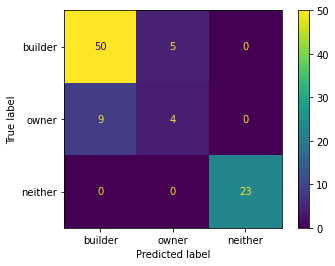

In [308]:
# Visualise Confusion Matrix
cm = confusion_matrix(y_test, predicted, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

From the confusion matrix, we can see that the classifier has trouble predicted the owner label more than the builder. This can be easily attributed to the skewed data distribution for the labels. If the labels were more balanced and there was more data, it is likely that the model will peform better.